<h1 align="center"> AVO ANALYSIS WITH FAR AND NEAR STACKING SEISMIC DATASETS </h3>

<h3> MASAPANTA POZO, John </h3>

Sunday, 22th December, 2020\
Stavanger-Norway

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import struct as st

# Function definitions

In [3]:
def spiking(trace, filter_length=11, epsilon=1e-3):
    # Autocorrelation function
    nt = trace.size
    A = np.convolve(trace[::-1], trace)
    A = A[nt-1:-1]
    norm = np.max(np.abs(A))
    A = A/norm

    # Setting up system
    nf = filter_length
    epsilon = 1
    M = np.zeros([nf,nf])
    for i in range(0,nf):
        for j in range(0,nf):
            M[i,j] = A[np.abs(i-j)]
            if(i==j):
                M[i,j] = M[i,j] + epsilon

    rhs = np.zeros([nf])
    rhs[0] = 1
    f = np.linalg.solve(M,rhs)
    tracespiked = np.convolve(trace, f)
    tracespiked = tracespiked[0:nt]
    return tracespiked

def plotdata(ax, data, time, distance):
    ax.imshow(data, extent=[distance[0], distance[-1], time[0], time[-1]], aspect=3000, cmap='seismic')
    ax.set_xlabel('midpoint (m)')
    ax.set_ylabel('Time (s)')

def plotimpedance(ax, data, time, distance):
    ax.imshow(data, extent=[distance[0], distance[-1], time[0], time[-1]], aspect=3000, cmap='rainbow')
    ax.set_xlabel('midpoint (m)')
    ax.set_ylabel('Time (s)')



# Reading seismic data and put in near and far arrays

In [4]:
nt = 251
nx = 801
dt = 4e-3
dx = 5
time = np.linspace(0,nt-1,nt)*dt + 1.5
distance = np.linspace(0,nx-1,nx)*dx

fullsize = nt*nx
fin = open('near.bin', 'rb')
near = np.zeros([fullsize,1])
near[0:fullsize,0] = st.unpack('f'*fullsize, fin.read(4*fullsize));
fin.close()
near = near.reshape([nt,nx])

fin = open('far.bin', 'rb')
far = np.zeros([fullsize,1])
far[0:fullsize,0] = st.unpack('f'*fullsize, fin.read(4*fullsize));
fin.close()
far = far.reshape([nt,nx])


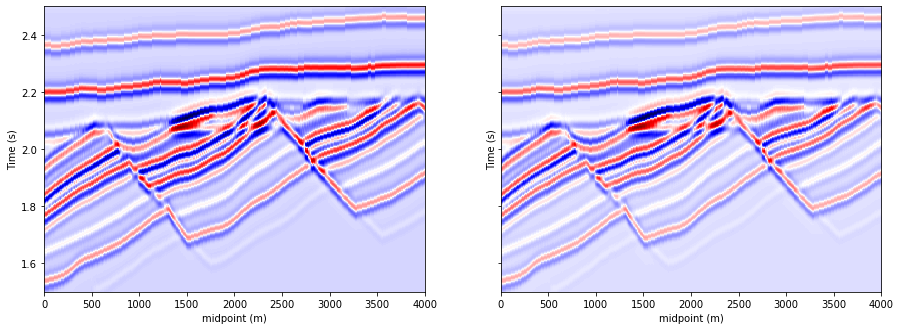

In [5]:
figs, axs = plt.subplots(1,2, sharey=True, figsize=(15,12))
plotdata(axs[0], near, time, distance)
plotdata(axs[1], far, time, distance)


## Computing the intercept (A) and gradient (B) 

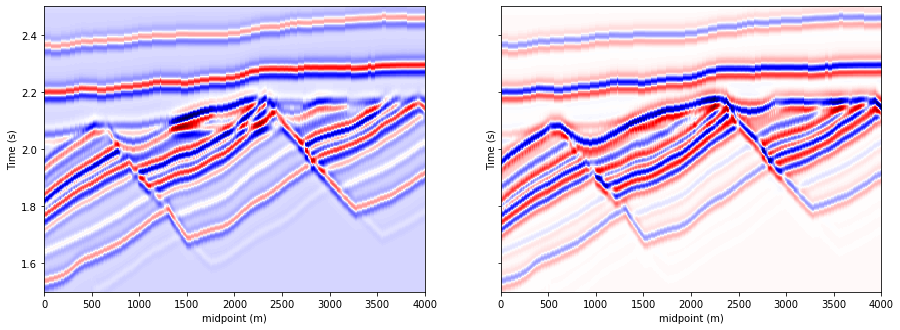

In [6]:
A = near
B = (far-near)/(np.sin(20*np.pi/180)**2)

figs, axs = plt.subplots(1,2, sharey=True, figsize=(15,12))
plotdata(axs[0], A, time, distance)
plotdata(axs[1], B, time, distance)


## Intercept vs gradient plot

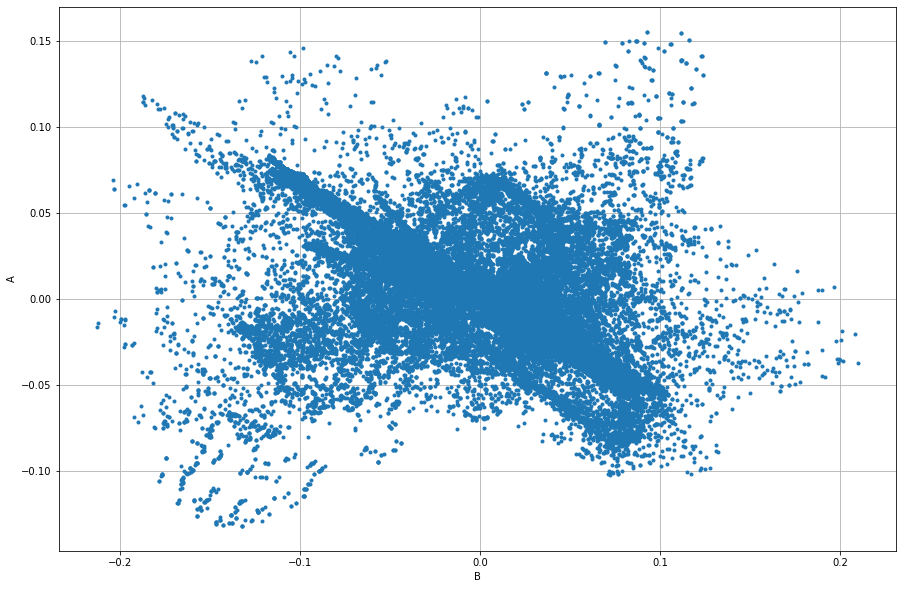

In [7]:
plt.subplots(figsize=(15,10))
plt.plot(B.reshape([nt*nx,1]),A.reshape([nt*nx,1]), '.')
plt.xlabel('B')
plt.ylabel('A')
plt.grid()

# Example of taking a subset of the data with "class 3" anomaly 

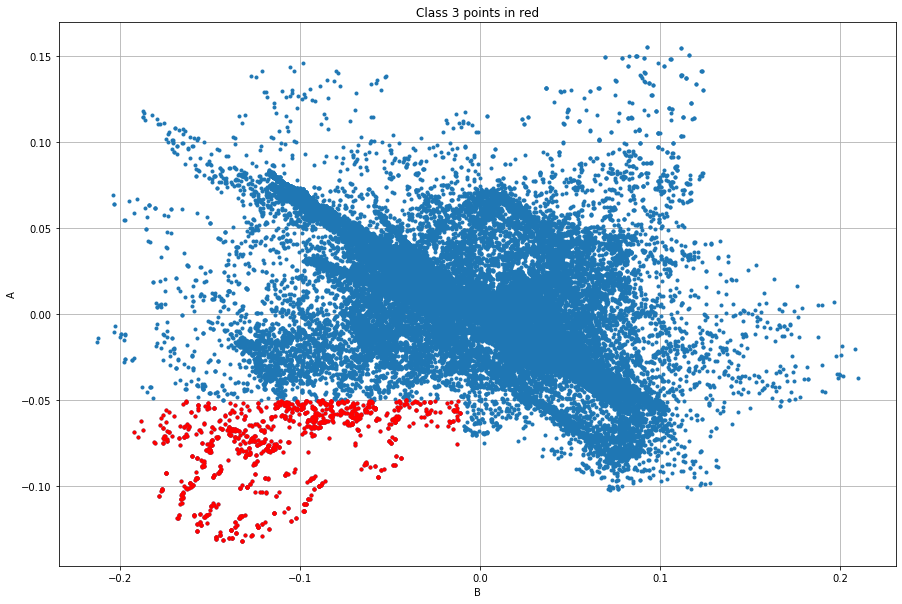

In [8]:
SubsetA = np.zeros(A.shape)
SubsetB = np.zeros(B.shape)
for ix in range(0,nx):
    for it in range(0,nt):
        if(A[it,ix] <=-0.05 and B[it,ix] <= -0.01):
            SubsetA[it,ix] = A[it,ix]
            SubsetB[it,ix] = B[it,ix]       

plt.subplots(figsize=(15,10))
plt.plot(B.reshape(nt*nx),A.reshape(nt*nx), '.')
for it in range(0,nt):
    for ix in range(0,nx):
        if(SubsetA[it,ix] != 0 and SubsetB[it,ix] != 0):
            plt.plot(SubsetB[it,ix],SubsetA[it,ix], 'r.')                    

plt.xlabel('B')
plt.ylabel('A')
plt.title('Class 3 points in red')
plt.grid()


# Plotting only Class-3 Anomalies

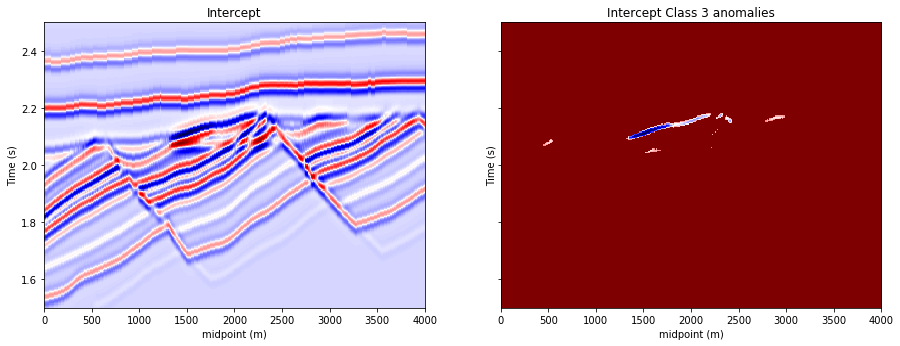

In [9]:
figs, axs = plt.subplots(1,2, sharey=True, figsize=(15,12))
plotdata(axs[0], A, time, distance)
plotdata(axs[1], SubsetA, time, distance)
axs[0].set_title('Intercept')
axs[1].set_title('Intercept Class 3 anomalies');

# Plotting Impedance

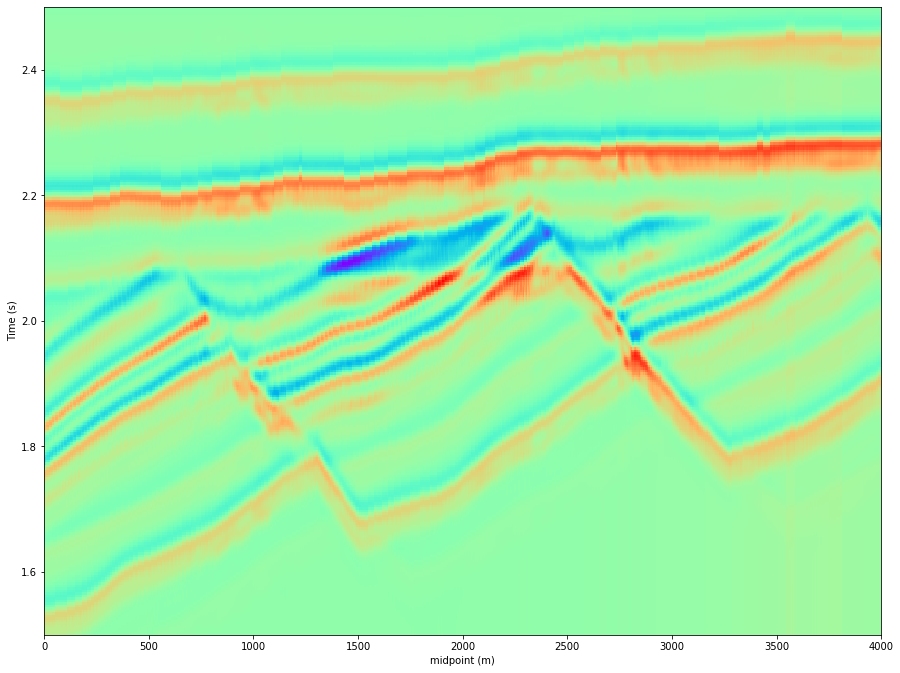

In [11]:
RC = np.zeros([nt,nx])
for ix in range(0,nx):
    trace_spiked = spiking(near[:,ix], 11, 1e-3)
    RC[:,ix] = trace_spiked

Z = np.ones([nt,nx])
for ix in range(0,nx):
    for it in range(0,nt-1):
        if(1-RC[it,ix] != 0):
            Z[it+1, ix] = Z[it,ix]*(1+RC[it,ix])/(1-RC[it,ix])
            
        
figs, axs = plt.subplots(1,1, sharey=True, figsize=(15,12))
plotimpedance(axs, Z, time, distance)